# **1. Import thư viện**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# **2. Chuẩn bị dữ liệu**

In [ ]:
df = pd.read_csv("ECommerce_Dataset_cleaned_model.csv")

In [ ]:
df.head()

,Churn,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,DaySinceLastOrder,CashbackAmount,DevicePerTenure
0,1,3,6,3,3,Laptop & Accessory,2,Single,9,1,11,1,5,160,0.75
1,1,1,8,3,4,Mobile Phone,3,Single,7,1,15,0,0,121,4.00
2,1,1,30,2,4,Mobile Phone,3,Single,6,1,14,0,3,120,4.00
3,1,3,15,2,4,Laptop & Accessory,5,Single,8,0,23,0,3,134,4.00
4,1,1,12,3,3,Mobile Phone,5,Single,3,0,11,1,3,130,3.00


In [ ]:
# Xác định biến đầu vào và mục tiêu
target = 'Churn'

X = df.drop(columns=[target])
y = df[target]

In [ ]:
# Xác định cột định lượng (numeric) và định tính (categorical)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# **3. Tạo Pipeline (Tiền xử lý + Mô hình)**

In [ ]:
# ColumnTransformer: One-Hot Encoding + Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

In [ ]:
#Xây dựng model
model = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True
)

In [ ]:
# Xây dựng Pipeline
clf = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# **4. Cross validation (10-fold)**

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict')
y_proba_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

roc_auc_cv = roc_auc_score(y_train, y_proba_cv)
print(f"CV ROC-AUC: {roc_auc_cv:.4f}")

CV ROC-AUC: 0.9192


# **5. Huấn luyện & dự đoán**

In [ ]:
# Train model
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CityTier',
                                                   'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount',
                                                   'DevicePerTenure']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('model', SVC(probability=True))])

In [ ]:
# Dự đoán
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

# **6. Đánh giá mô hình**

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       936
           1       0.82      0.62      0.71       190

    accuracy                           0.91      1126
   macro avg       0.87      0.80      0.83      1126
weighted avg       0.91      0.91      0.91      1126



**Nhận xét:** Mô hình SVM (RBF) Classifier đạt **accuracy khoảng 91%** và **F1-score trung bình 0.91**, cho thấy mô hình có hiệu quả phân loại tổng thể khá tốt trên tập test.

- **Đối với lớp 0:** mô hình đạt **precision 0.93** và **recall rất cao 0.97** cho thấy hầu hết khách hàng không churn được dự đoán chính xác. **F1-score 0.95** phản ánh sự cân bằng tốt giữa độ chính xác và khả năng bao phủ của lớp này, đồng thời số lượng nhầm lẫn sang lớp churn là không đáng kể.

- **Đối với lớp 1:** mô hình đạt **precision 0.82** và **recall đạt 0.62** cho thấy mô hình có khả năng phát hiện khách hàng churn ở mức trung bình, tuy nhiên vẫn bỏ sót một số trường hợp churn. **F1-score 0.71** phản ánh sự đánh đổi giữa việc phát hiện churn và hạn chế dự đoán sai từ lớp không churn sang churn.

Nhìn chung mô hình hoạt động rất tốt trong việc phân loại **khách hàng không churn** và đạt độ chính xác tổng thể cao. Tuy nhiên, khả năng phát hiện khách hàng churn vẫn còn hạn chế, thể hiện qua giá trị recall của lớp này chưa cao. Điều này cho thấy mô hình có xu hướng hạn chế dự đoán nhầm (false positive) hơn là cố gắng phát hiện tối đa churn. Cách tiếp cận này phù hợp trong những trường hợp cần giảm cảnh báo sai, nhưng vẫn có thể được cải thiện thêm nếu mục tiêu ưu tiên là phát hiện sớm khách hàng churn

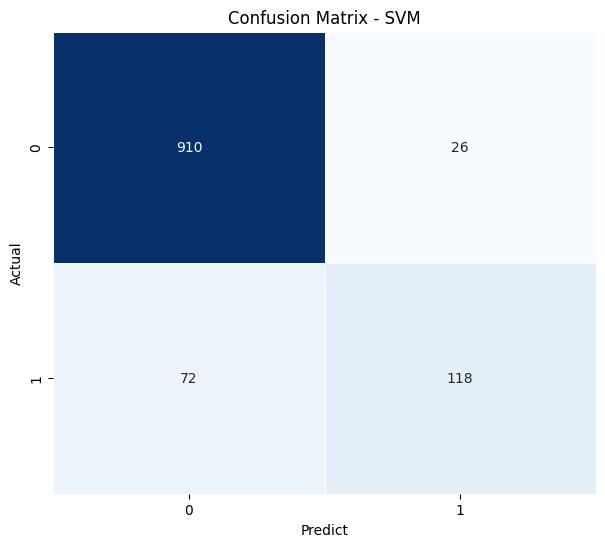

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=False, linewidths=0.5)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

**Nhận xét:**
- Mô hình dự đoán 118 khách hàng có khả năng rời bỏ giúp doanh nghiệp xác định đúng nhóm cần triển khai các chiến lược giữ chân.
- Xác định đúng 910 khách hàng trung thành, góp phần hạn chế việc tiếp cận không cần thiết và tối ưu chi phí chăm sóc khách hàng.
- Mô hình dự đoán nhầm 26 khách hàng trung thành là churn, có thể gây phát sinh chi phí chăm sóc không cần thiết.
- Mô hình vẫn chưa phát hiện được 72 khách hàng thực sự rời bỏ , đây là nhóm lỗi quan trọng do có thể dẫn đến việc bỏ sót khách hàng có nguy cơ churn.

Với tổng số lỗi là 98 trên 1126 mẫu kiểm tra, độ chính xác tổng thể đạt 91.29%, cho thấy mô hình có hiệu quả khá tốt nhưng vẫn cần cải thiện khả năng phát hiện churn.

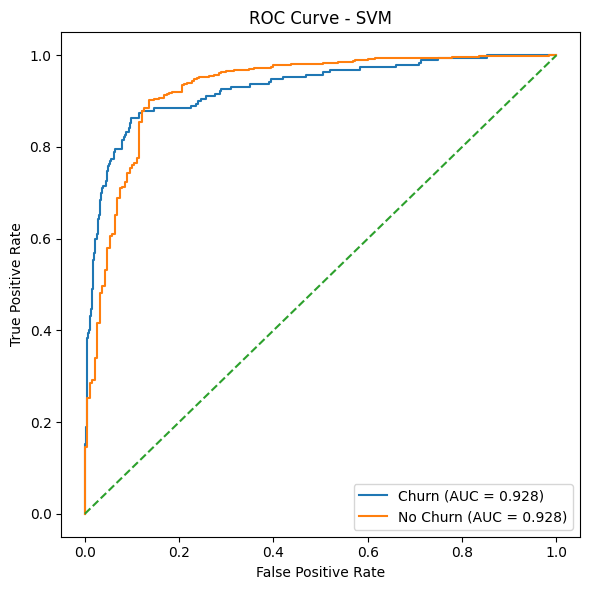

In [ ]:
# vẽ ROC Curve

# Lớp churn = 1
fpr_1, tpr_1, _ = roc_curve(y_test, y_proba[:, 1])
auc_1 = auc(fpr_1, tpr_1)

# Lớp churn = 0
fpr_0, tpr_0, _ = roc_curve(1 - y_test, y_proba[:, 0])
auc_0 = auc(fpr_0, tpr_0)

plt.figure(figsize=(6, 6))
plt.plot(fpr_1, tpr_1, label=f'Churn (AUC = {auc_1:.3f})')
plt.plot(fpr_0, tpr_0, label=f'No Churn (AUC = {auc_0:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.tight_layout()
plt.show()

**Nhận xét:**
- Diện tích dưới đường cong ROC (AUC) của mô hình SVM đạt 0.928, cho thấy mô hình có khả năng phân biệt tốt giữa khách hàng có khả năng rời bỏ và khách hàng ở lại.
- Đường cong ROC nằm về phía bên trái cho thấy mô hình đạt tỷ lệ phát hiện churn cao trong khi vẫn kiểm soát tốt số lượng dự đoán sai, phản ánh khả năng phân loại hiệu quả.